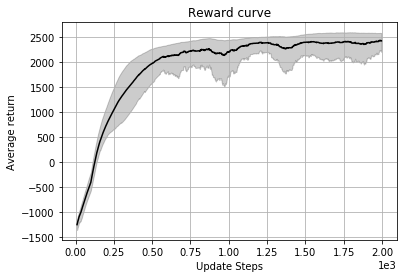

In [9]:
# %%
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
import numpy as np
import os
import matplotlib.pyplot as plt
import gym
from gym.wrappers import TimeLimit
import pybullet_envs
import pybullet as p
import time
import torch
from stable_baselines import SAC, TD3, PPO2, A2C, TRPO
import sys
from seagul.envs.wrappers.time_wrappers import TimeFeatureWrapper

def make_env(env_id, rank=0, seed=0, log_dir=None, wrapper_class=None, env_kwargs=None):
    """
    Helper function to multiprocess training
    and log the progress.
    :param env_id: (str)
    :param rank: (int)
    :param seed: (int)
    :param log_dir: (str)
    :param wrapper: (type) a subclass of gym.Wrapper to wrap the original
                    env with
    :param env_kwargs: (Dict[str, Any]) Optional keyword argument to pass to the env constructor
    """
    if log_dir is not None:
        os.makedirs(log_dir, exist_ok=True)

    if env_kwargs is None:
        env_kwargs = {}

    def _init():
        set_global_seeds(seed + rank)
        env = gym.make(env_id, **env_kwargs)

        # Dict observation space is currently not supported.
        # https://github.com/hill-a/stable-baselines/issues/321
        # We allow a Gym env wrapper (a subclass of gym.Wrapper)
        if wrapper_class:
            env = wrapper_class(env)

        env.seed(seed + rank)
        log_file = os.path.join(log_dir, str(rank)) if log_dir is not None else None
        env = Monitor(env, log_file)
        return env

    return _init


sys.path.append("/home/sgillen/work/external/rl-baselines-zoo/")
import utils

def do_rollout_stable(render=True):
    env.seed(int(time.time())*10)

    acts_list = []
    obs1_list = []
    rews_list = []
    
    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0
    total_steps = 0

    obs = env.reset()
    while not done:
        acts = model.predict(obs)[0]
        obs, rew, done, out = env.step(acts)
      
        if render:
            pass
            #env.render()
            #time.sleep(.02)
            
        obs1_list.append(obs)
        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)

    return ep_obs1, ep_acts, ep_rews


log_dir = '/home/sgillen/work/lorenz/run_stable/ppo_pbmj/cht/bullet/'
df_list = []

min_length = float('inf')
for entry in os.scandir(log_dir):
    if "ipy" in entry.path:
        continue

    df = load_results(entry.path)

    if len(df['r']) < min_length:
        min_length = len(df['r'])

    df_list.append(df)

    
min_length = int(min_length)    
rewards = np.zeros((min_length, len(df_list)))
for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

fig, ax = smooth_bounded_curve(rewards[:min_length])

ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

In [11]:
#from stable_baselines.
from stable_baselines.common.vec_env import VecNormalize, SubprocVecEnv, DummyVecEnv 
log_dir = "/home/sgillen/work/lorenz/run_stable/ppo_pbmj/cht/mujoco/HalfCheetah-v2_1"
#model = PPO2.load("/home/sgillen/work/lorenz/run_stable/ppo_pbmj/cht/bullet/HalfCheetahBulletEnv-v0_1/best_model.zip")
model = PPO2.load("/home/sgillen/work/lorenz/run_stable/ppo_pbmj/cht/mujoco/HalfCheetah-v2_1/best_model.zip")

render = False

env = SubprocVecEnv([make_env("HalfCheetah-v2",0,0,log_dir,wrapper_class=TimeFeatureWrapper)])
#env = TimeFeatureWrapper(gym.make("HalfCheetah-v2"))
env = VecNormalize.load("/home/sgillen/work/lorenz/run_stable/ppo_pbmj/cht/mujoco/HalfCheetah-v2_1/HalfCheetah-v2/vecnormalize.pkl", env)
#env = TimeFeatureWrapper(gym.make("Walker2DBulletEnv-v0", render=render))
#p.disconnect()

obs,acts,rews = do_rollout_stable(render=False)

print(sum(rews))

#env.num_steps=int(1e8)
#env._max_episode_steps = int(1e8)
#env._max_steps = int(1e8)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


ConnectionResetError: [Errno 104] Connection reset by peer